In [287]:
# Libraries and helper functions

%matplotlib inline
import matplotlib.pyplot as plt
from IPython.display import Image

import numpy as np
from itertools import product
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

from qutip import *
from qutip.piqs import *
from qutip.cy.piqs import j_min, j_vals, m_vals

from scipy.stats import linregress
from scipy.signal import find_peaks
from scipy.optimize import curve_fit

# The helper file below brings functions created in previous tutorials
from libs.helper_09_tutorial import *

In [288]:
H_latex = "$H = \Delta E /2 (\sigma_{z1} + \sigma_{z2}) + \hbar\omega(a^{{\dagger}}a +1/2) + U( a^{{\dagger}} + a )(\sigma_{x1} +\sigma_{x2} )$ "

# Damping on TLS2

In [289]:
def make_operators(max_bosons, parity=0):
    a     = tensor(destroy(max_bosons+1), qeye(2), qeye(2))     # tensorised boson destruction operator
    sx1   = tensor(qeye(max_bosons+1), sigmax(), qeye(2))       # tensorised 𝜎𝑥1 operator 
    sx2   = tensor(qeye(max_bosons+1), qeye(2), sigmax())       # tensorised 𝜎𝑥2 operator 
    sz1   = tensor(qeye(max_bosons+1), sigmaz(), qeye(2))       # tensorised 𝜎z1 operator 
    sz2   = tensor(qeye(max_bosons+1), qeye(2), sigmaz())       # tensorised 𝜎z2 operator
    sigm1 = tensor(qeye(max_bosons+1), sigmam(), qeye(2))
    sigm2 = tensor(qeye(max_bosons+1), qeye(2), sigmam())
    
    two_state_1     =  1/2*sz1                                  # two state system energy operator   𝜎𝑧1/2
    two_state_2     =  1/2*sz2                                  # two state system energy operator   𝜎𝑧2/2
    bosons          = (a.dag()*a+0.5)                           # boson energy operator              𝑎†𝑎+1/2
    number          = a.dag()*a                                 # boson number operator              𝑎†𝑎
    interaction_1   = (a.dag() + a) * sx1                       # interaction energy operator       (𝑎†+𝑎)𝜎𝑥1  
    interaction_2   = (a.dag() + a) * sx2                       # interaction energy operator       (𝑎†+𝑎)𝜎𝑥2 
    # damping         = -1j*(1-sz1)*(1-sz2)/4
    # damping         = -1j*( (1-sz1)/2 + (1-sz2)/2)
    damping         = -1j*(1+sz2)/2
    
    P = sz1*sz2*(1j*np.pi*number).expm()                        # parity operator 
    
    # map from QuTiP number states to |n,±, ±> states
    possible_ns = range(0, max_bosons+1)
    possible_ms = ["+","-"]
    nmm_list = [(n,m1,m2) for (n,m1,m2) in product(possible_ns, possible_ms, possible_ms)]
    
    # only do parity extraction if a valid parity is being used
    if (parity==1) | (parity==-1):
        p           = np.where(P.diag()==parity)[0]
    else:
        p               = np.where(P.diag()==P.diag())[0]
    
    two_state_1     = two_state_1.extract_states(p)
    two_state_2     = two_state_2.extract_states(p)
    bosons          = bosons.extract_states(p)
    number          = number.extract_states(p)
    interaction_1   = interaction_1.extract_states(p)
    interaction_2   = interaction_2.extract_states(p)
    P               = P.extract_states(p)
    damping         = damping.extract_states(p)
    sigm1 = sigm1.extract_states(p)
    sigm2 = sigm2.extract_states(p)
    
    nmm_list        = [nmm_list[i] for i in p]

    return two_state_1, two_state_2, bosons, interaction_1, interaction_2, number, damping, sigm1, sigm2, nmm_list

In [290]:
omega = 1

In [291]:
U = 0.1

In [292]:
max_bosons = 1

In [293]:
parity = 0

In [294]:
two_state_1, two_state_2, bosons, interaction_1, interaction_2, number, damping, sigm1, sigm2, nmm_list = make_operators(max_bosons=max_bosons, parity=parity)

In [295]:
bra_labels, ket_labels = make_braket_labels(nmm_list)

In [296]:
H = 1*two_state_1 + 1*two_state_2 + 1*bosons + 1*interaction_1 + 1*interaction_2 + 0*damping

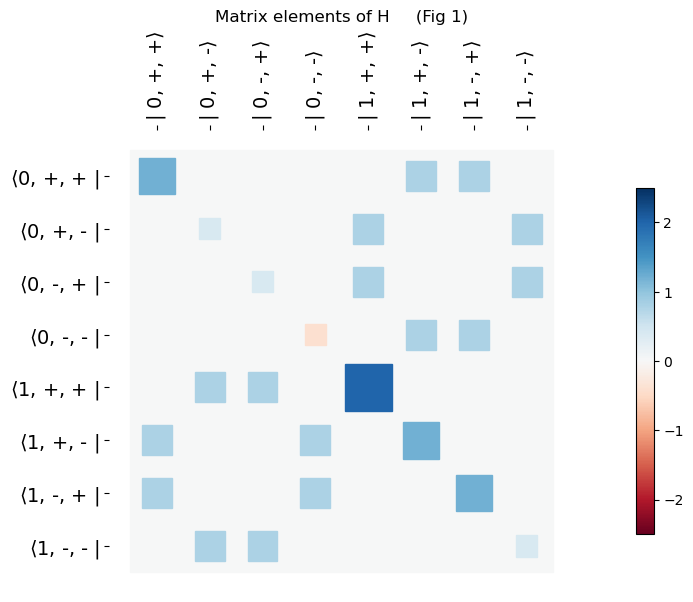

In [297]:
f, ax = hinton(H, xlabels=ket_labels, ylabels=bra_labels)
ax.tick_params(axis='x',labelrotation=90)
ax.set_title("Matrix elements of H     (Fig 1)");

In [312]:
nmm_list

[(0, '+', '+'),
 (0, '+', '-'),
 (0, '-', '+'),
 (0, '-', '-'),
 (1, '+', '+'),
 (1, '+', '-'),
 (1, '-', '+'),
 (1, '-', '-')]

## No damping

In [298]:
# deltaE = 10
# omega = 0.1
# U = 0.01


deltaE = 2.5
omega = 1
U = 0.01



In [299]:
projection_operators = [basis(len(nmm_list), i) * basis(len(nmm_list), i).dag() for i in range(len(nmm_list))]

In [300]:
psi0 = basis(len(nmm_list), 1)
times = np.linspace(0.0, 100000, 10000)
H = deltaE*two_state_1 + deltaE*two_state_2 + omega*bosons + U*interaction_1 + U*interaction_2
result = sesolve(H, psi0, times, projection_operators)

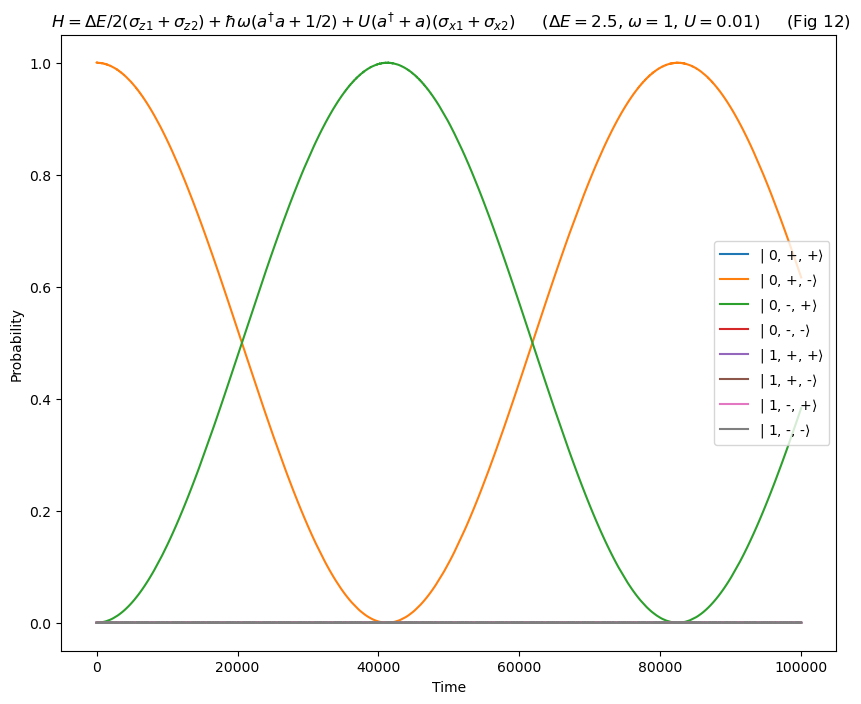

In [301]:
plt.figure(figsize=(10,8))
for i in range(0,len(result.expect)):
    plt.plot(times, result.expect[i][:], label=f"{ket_labels[i]}")
plt.ylabel("Probability")
plt.xlabel("Time")
plt.legend(loc="right")
plt.title(f" {H_latex}    ($\Delta E={deltaE}$, $\omega={omega}$, $U={U}$)     (Fig 12)")
plt.show();

In [476]:
2*np.pi/80000

7.853981633974483e-05

## Add some damping

### Small damping

In [534]:
gamma = 0.0005

In [535]:
# opts = Options(normalize_output=False)

In [540]:
psi0 = basis(len(nmm_list), 2)
times = np.linspace(0.0, 5000000, 100000)
H = deltaE*two_state_1 + deltaE*two_state_2 + omega*bosons + U*interaction_1 + U*interaction_2 + gamma*damping
result = sesolve(H, psi0, times, projection_operators)

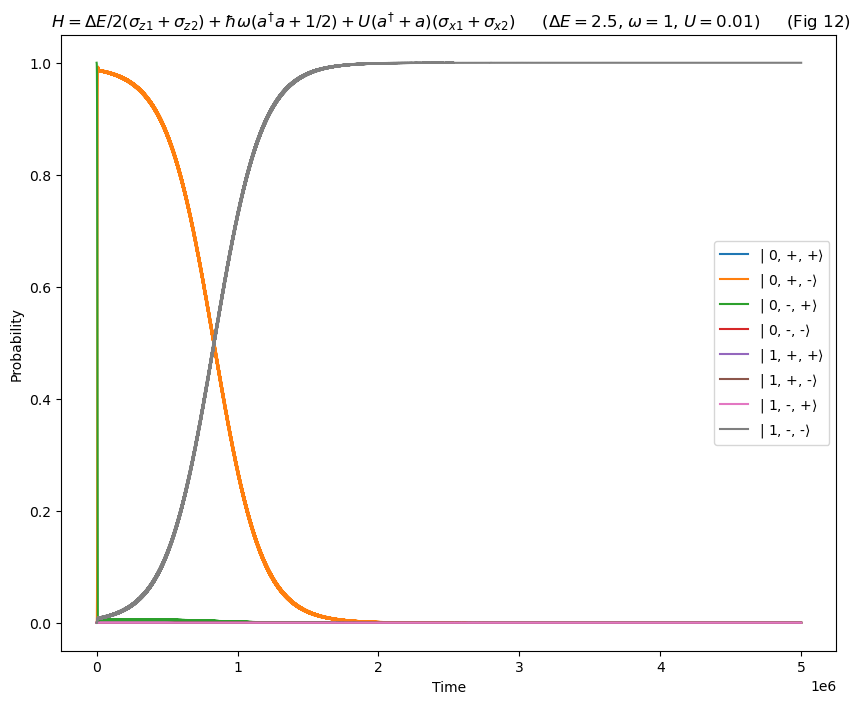

In [541]:
plt.figure(figsize=(10,8))
for i in range(0,len(result.expect)):
    plt.plot(times, result.expect[i][:], label=f"{ket_labels[i]}")
plt.ylabel("Probability")
plt.xlabel("Time")
plt.legend(loc="right")
plt.title(f" {H_latex}    ($\Delta E={deltaE}$, $\omega={omega}$, $U={U}$)     (Fig 12)")
plt.show();

### Significant damping

In [346]:
gamma = 1

In [347]:
psi0 = basis(len(nmm_list), 2)
times = np.linspace(0.0, 1000000, 20000)
H = deltaE*two_state_1 + deltaE*two_state_2 + omega*bosons + U*interaction_1 + U*interaction_2 + gamma*damping
result = sesolve(H, psi0, times, projection_operators)

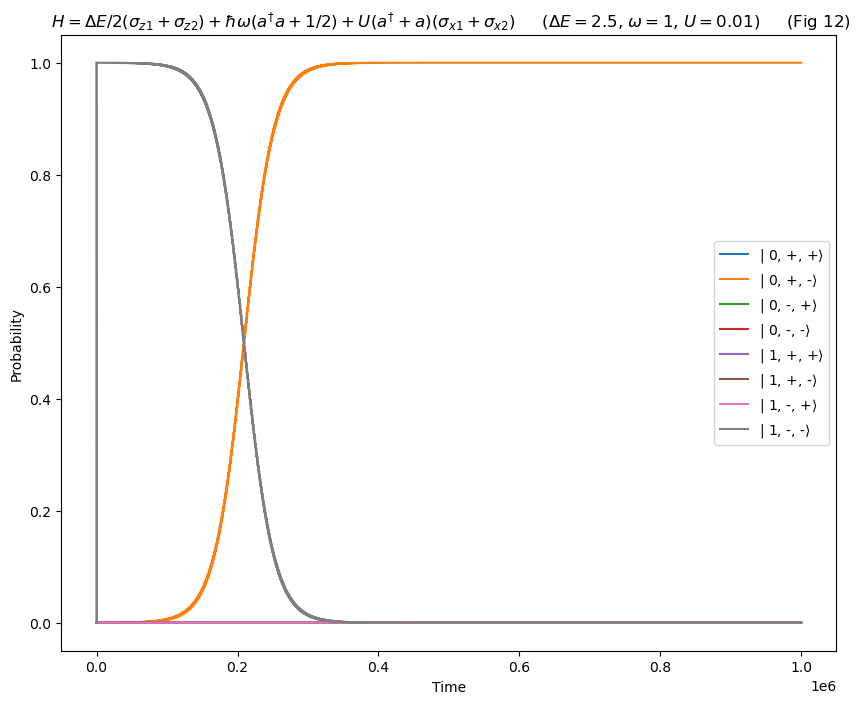

In [348]:
plt.figure(figsize=(10,8))
for i in range(0,len(result.expect)):
    plt.plot(times, result.expect[i][:], label=f"{ket_labels[i]}")
plt.ylabel("Probability")
plt.xlabel("Time")
plt.legend(loc="right")
plt.title(f" {H_latex}    ($\Delta E={deltaE}$, $\omega={omega}$, $U={U}$)     (Fig 12)")
plt.show();

### Large damping

In [309]:
gamma = 10

In [310]:
psi0 = basis(len(nmm_list), 1)
times = np.linspace(0.0, 100000, 100000)
H = deltaE*two_state_1 + deltaE*two_state_2 + omega*bosons + U*interaction_1 + U*interaction_2 + gamma*damping
result = sesolve(H, psi0, times, projection_operators)

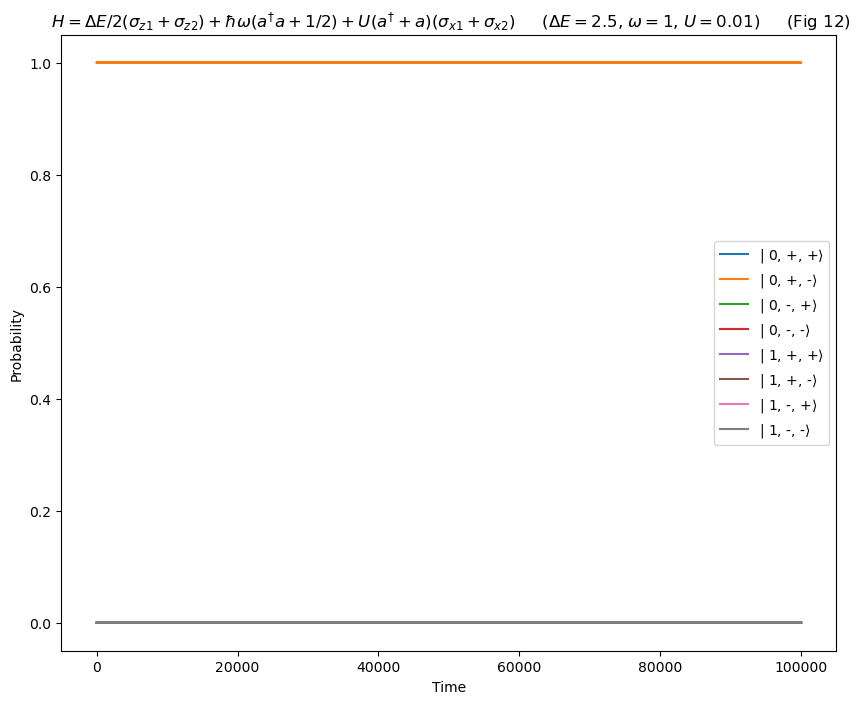

In [311]:
plt.figure(figsize=(10,8))
for i in range(0,len(result.expect)):
    plt.plot(times, result.expect[i][:], label=f"{ket_labels[i]}")
plt.ylabel("Probability")
plt.xlabel("Time")
plt.legend(loc="right")
plt.title(f" {H_latex}    ($\Delta E={deltaE}$, $\omega={omega}$, $U={U}$)     (Fig 12)")
plt.show();

In [202]:
gamma = 100

In [203]:
psi0 = basis(len(nmm_list), 1)
times = np.linspace(0.0, 100000, 100000)
H = deltaE*two_state_1 + deltaE*two_state_2 + omega*bosons + U*interaction_1 + U*interaction_2 + gamma*damping
result = sesolve(H, psi0, times, projection_operators)

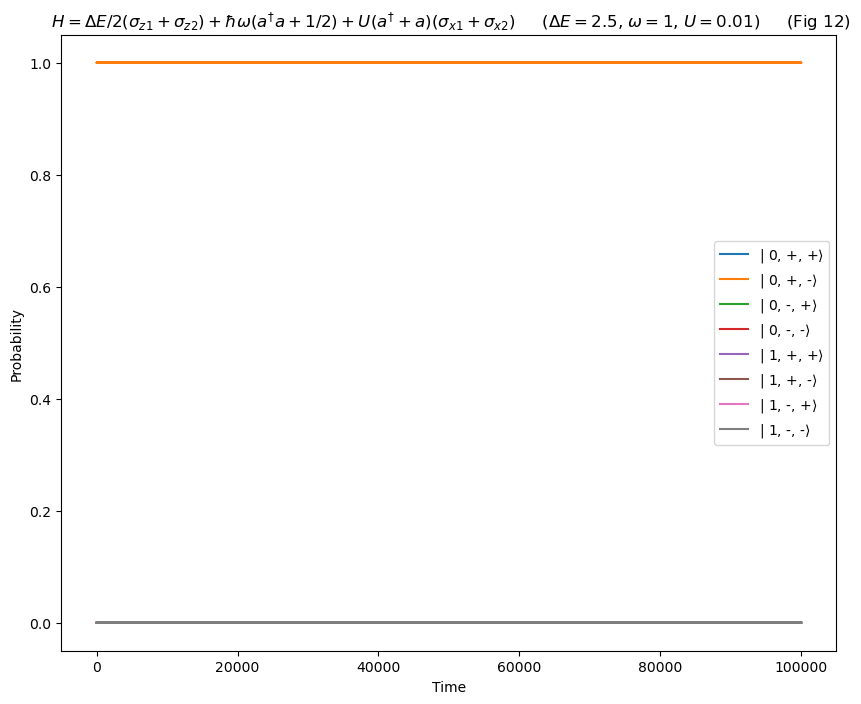

In [204]:
plt.figure(figsize=(10,8))
for i in range(0,len(result.expect)):
    plt.plot(times, result.expect[i][:], label=f"{ket_labels[i]}")
plt.ylabel("Probability")
plt.xlabel("Time")
plt.legend(loc="right")
plt.title(f" {H_latex}    ($\Delta E={deltaE}$, $\omega={omega}$, $U={U}$)     (Fig 12)")
plt.show();

In [316]:
def simulate(H, psi0, times, evals=None, ekets=None):
    """
    Solves the time-independent Schrödinger equation and normalizes state if non-Hermitian.
    
    Parameters
    ----------
    H     : QuTiP Qobj, Hamiltonian for the system you want to simulate
    psi0  : QuTiP Qobj, Initial state of the system
    times : 1D numpy array, Times to evaluate the state of the system
    evals : Result of a previous H.eigenstates() calculation
    ekets : Result of a previous H.eigenstates() calculation

    Returns
    -------
    P     : numpy array, Occupation probabilities for each basis state over time
    psi   : numpy array, State vectors over time
    evals : Output from QuTiP's H.eigenstates()
    ekets : Output from QuTiP's H.eigenstates()
    """
    num_states = H.shape[0]

    # Initialize the psi matrix
    psi = np.zeros((num_states, len(times)), dtype=complex)
    if evals is None or ekets is None:
        evals, ekets = H.eigenstates()
    psi0_in_H_basis = psi0.transform(ekets)  

    # Pre-compute the exponential factor outside the loop for all evals and times
    exp_factors = np.exp(-1j * np.outer(evals, times))

    # Check if Hamiltonian is Hermitian
    is_hermitian = H.isherm

    # Vectorized computation for each eigenstate's contribution
    for i, e in enumerate(ekets):
        psi += np.outer(psi0_in_H_basis[i] * e.full(), exp_factors[i, :])

    # Normalize psi if H is not Hermitian
    if not is_hermitian:
        # Normalize at each time step to ensure total probability is 1
        norm_factors = np.linalg.norm(psi, axis=0)
        psi /= norm_factors

    # Compute probabilities from psi
    P = np.abs(psi)**2

    return P, psi

In [320]:
gamma = 1
H = deltaE*two_state_1 + deltaE*two_state_2 + omega*bosons + U*interaction_1 + U*interaction_2 + gamma*damping
times = np.linspace(0.0, 100000000000, 20000)

In [359]:
times = np.linspace(0.0, 10000, 20000)
P, psi = simulate(H, psi0, times)

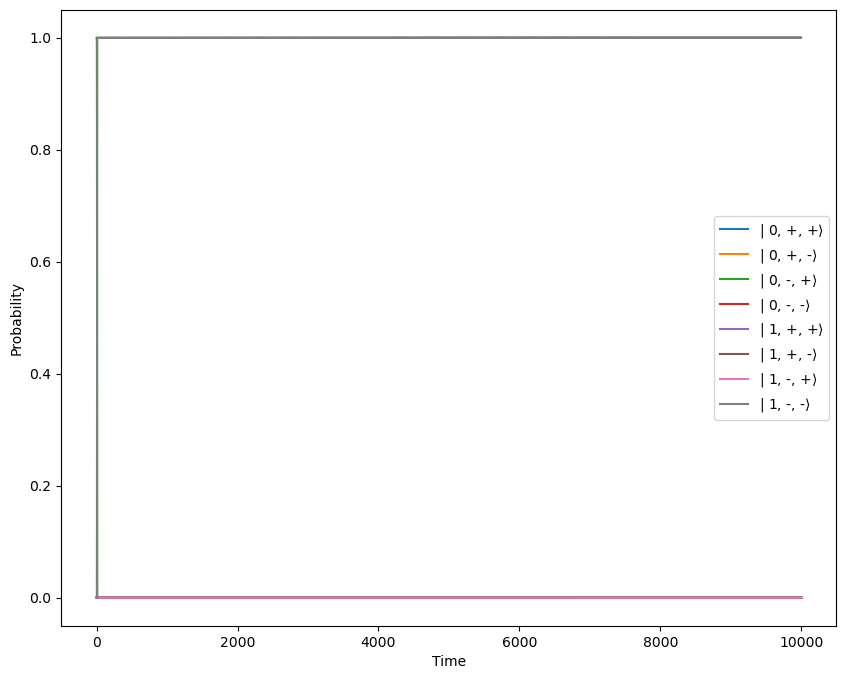

In [360]:
plot_sim(times, P, ket_labels)

In [186]:
H

Quantum object: dims = [[8], [8]], shape = (8, 8), type = oper, isherm = False
Qobj data =
[[ 3.  -1.j  0.  +0.j  0.  +0.j  0.  +0.j  0.  +0.j  0.01+0.j  0.01+0.j
   0.  +0.j]
 [ 0.  +0.j  0.5 +0.j  0.  +0.j  0.  +0.j  0.01+0.j  0.  +0.j  0.  +0.j
   0.01+0.j]
 [ 0.  +0.j  0.  +0.j  0.5 -1.j  0.  +0.j  0.01+0.j  0.  +0.j  0.  +0.j
   0.01+0.j]
 [ 0.  +0.j  0.  +0.j  0.  +0.j -2.  +0.j  0.  +0.j  0.01+0.j  0.01+0.j
   0.  +0.j]
 [ 0.  +0.j  0.01+0.j  0.01+0.j  0.  +0.j  4.  -1.j  0.  +0.j  0.  +0.j
   0.  +0.j]
 [ 0.01+0.j  0.  +0.j  0.  +0.j  0.01+0.j  0.  +0.j  1.5 +0.j  0.  +0.j
   0.  +0.j]
 [ 0.01+0.j  0.  +0.j  0.  +0.j  0.01+0.j  0.  +0.j  0.  +0.j  1.5 -1.j
   0.  +0.j]
 [ 0.  +0.j  0.01+0.j  0.01+0.j  0.  +0.j  0.  +0.j  0.  +0.j  0.  +0.j
  -1.  +0.j]]

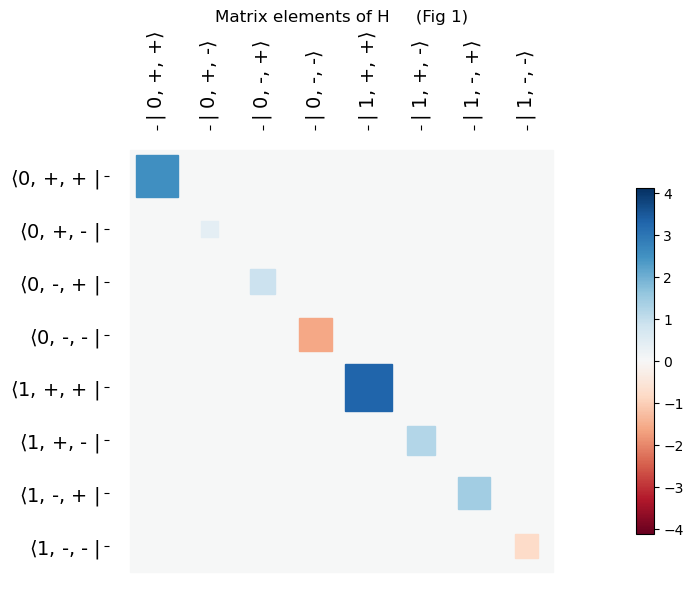

In [187]:
f, ax = hinton(H, xlabels=ket_labels, ylabels=bra_labels)
ax.tick_params(axis='x',labelrotation=90)
ax.set_title("Matrix elements of H     (Fig 1)");

In [649]:
data = mcsolve(H, psi0, times, [np.sqrt(gamma) * (sigm1*sigm2)], e_ops=[two_state_1 + 1/2,two_state_2 + 1/2])

10.0%. Run time:   1.38s. Est. time left: 00:00:00:12
20.0%. Run time:   2.60s. Est. time left: 00:00:00:10


KeyboardInterrupt: 

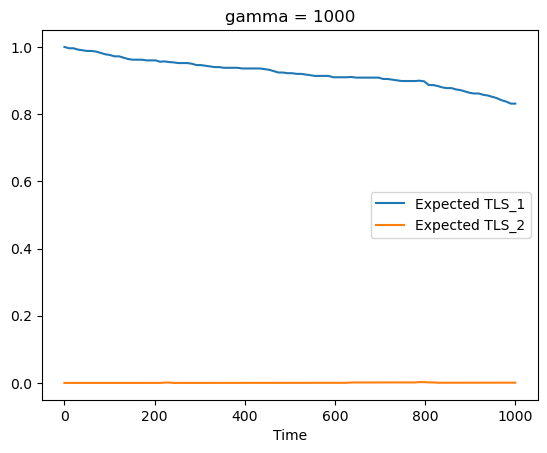

In [594]:
plt.plot(times, data.expect[0], label="Expected TLS_1")
plt.plot(times, data.expect[1], label="Expected TLS_2")
plt.xlabel("Time")
plt.title(f"gamma = {gamma}")
plt.legend(loc="right")

In [612]:
dir(data)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 'col_times',
 'col_which',
 'expect',
 'ntraj',
 'num_collapse',
 'num_expect',
 'options',
 'seeds',
 'solver',
 'states',
 'times']

In [614]:
data.ntraj

500

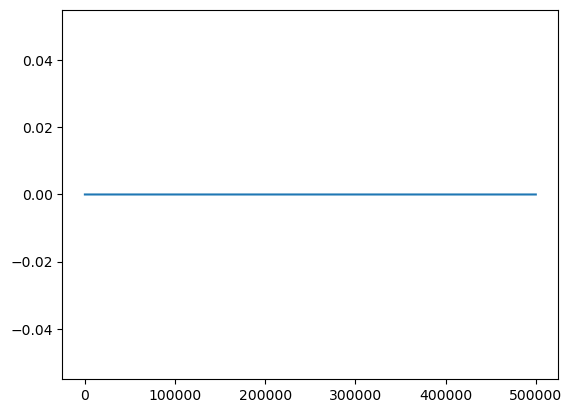

In [421]:
plt.plot(times,P[8,:])

In [290]:
num_1 = expectation(two_state_1 + 1/2, psi)
num_2 = expectation(two_state_2 + 1/2, psi)

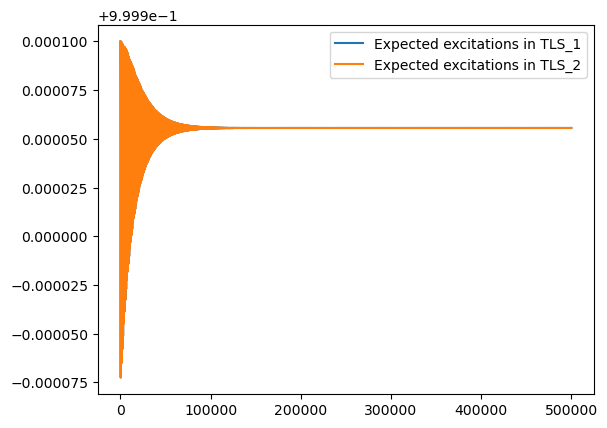

In [291]:
plt.plot(times, num_1, label="Expected excitations in TLS_1")
plt.plot(times, num_2, label="Expected excitations in TLS_2")
plt.legend()
plt.show()

In [292]:
nmm_list

[(0, '+', '+'),
 (0, '+', '-'),
 (0, '-', '+'),
 (0, '-', '-'),
 (1, '+', '+'),
 (1, '+', '-'),
 (1, '-', '+'),
 (1, '-', '-'),
 (2, '+', '+'),
 (2, '+', '-'),
 (2, '-', '+'),
 (2, '-', '-')]

In [1346]:
psi0 = basis(len(nmm_list), 3)
times = np.linspace(0.0, 400000000, 100000)
P, psi, evals, ekets = simulate(H, psi0, times)

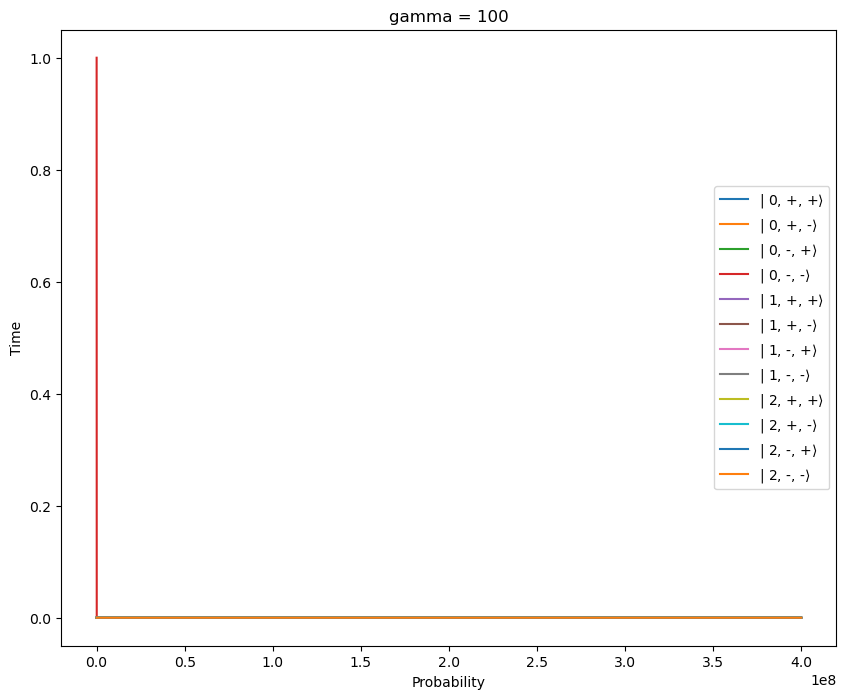

In [1347]:
plot_sim(times, P, ket_labels)
plt.title(f"gamma = 100");

In [1186]:
times = np.linspace(0.0, 700000.0, 1000000)

In [895]:
result = sesolve(H, psi0, times, [two_state_1 + 1/2,two_state_2 + 1/2])

Text(0.5, 0, 'Time')

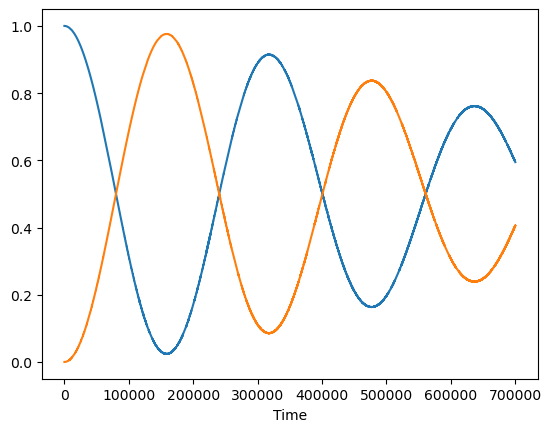

In [896]:
plt.plot(times, result.expect[0], label="Expected TLS_1")
plt.plot(times, result.expect[1], label="Expected TLS_2")
plt.xlabel("Time")

In [926]:
opts = Options(normalize_output=False)
projection_operators = [basis(len(nmm_list), i) * basis(len(nmm_list), i).dag() for i in range(len(nmm_list))]
result = sesolve(H, psi0, times, projection_operators,options=opts)

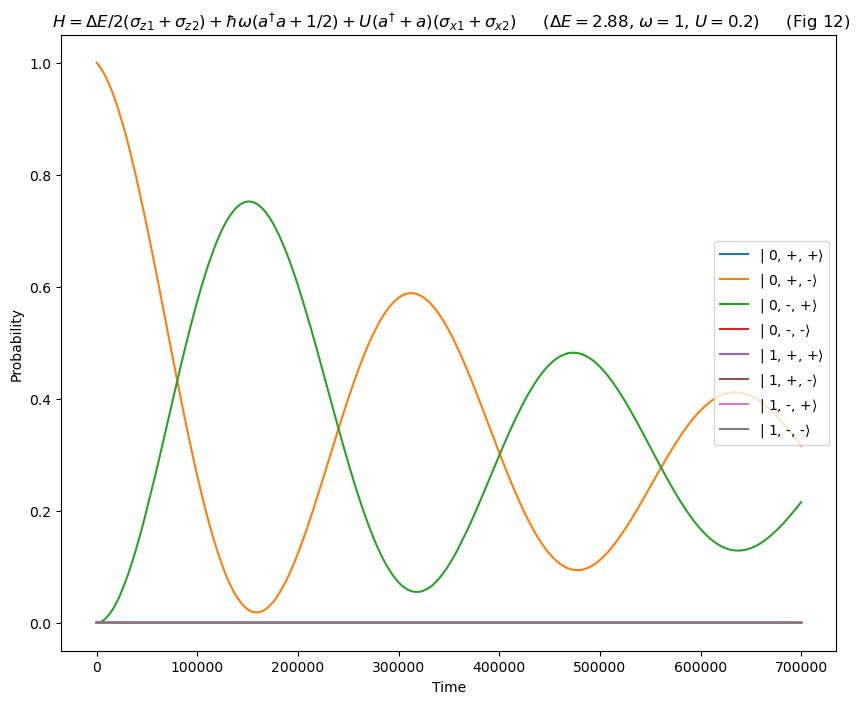

In [927]:
plt.figure(figsize=(10,8))
for i in range(0,len(result.expect)):
    plt.plot(times, result.expect[i][:], label=f"{ket_labels[i]}")
plt.ylabel("Probability")
plt.xlabel("Time")
plt.legend(loc="right")
plt.title(f" {H_latex}    ($\Delta E=2.88$, $\omega=1$, $U=0.2$)     (Fig 12)")
plt.show();

In [1159]:
deltaE = 2.5
omega = 1
U = 0.1

In [1160]:
gamma = 200

In [1161]:
nmm_list

[(0, '+', '+'),
 (0, '+', '-'),
 (0, '-', '+'),
 (0, '-', '-'),
 (1, '+', '+'),
 (1, '+', '-'),
 (1, '-', '+'),
 (1, '-', '-'),
 (2, '+', '+'),
 (2, '+', '-'),
 (2, '-', '+'),
 (2, '-', '-')]

In [1162]:
psi0 = basis(len(nmm_list), 5)

In [1176]:
times = np.linspace(0.0, 3000.0, 100)

In [1177]:
H = deltaE*two_state_1 + deltaE*two_state_2 + omega*bosons + U*interaction_1 + U*interaction_2

In [1178]:
data = mcsolve(H, psi0, times, [np.sqrt(100) * sigm1*sigm2], e_ops=[two_state_1 + 1/2,two_state_2 + 1/2])

10.0%. Run time:  32.00s. Est. time left: 00:00:04:47
20.0%. Run time:  61.28s. Est. time left: 00:00:04:05
30.0%. Run time:  92.92s. Est. time left: 00:00:03:36
40.0%. Run time: 125.68s. Est. time left: 00:00:03:08
50.0%. Run time: 159.93s. Est. time left: 00:00:02:39
60.0%. Run time: 191.20s. Est. time left: 00:00:02:07
70.0%. Run time: 222.41s. Est. time left: 00:00:01:35
80.0%. Run time: 254.71s. Est. time left: 00:00:01:03
90.0%. Run time: 288.01s. Est. time left: 00:00:00:32
100.0%. Run time: 318.54s. Est. time left: 00:00:00:00
Total run time: 318.55s


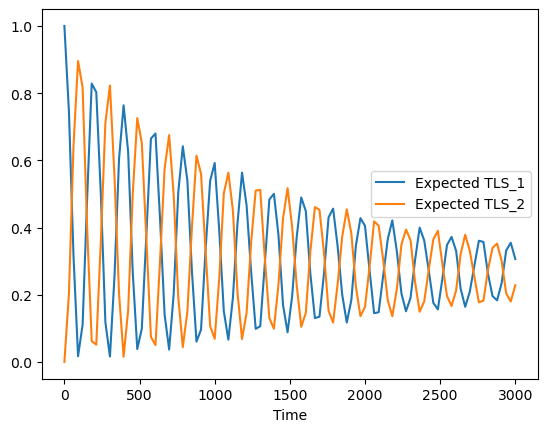

In [1180]:
plt.plot(times, data.expect[0], label="Expected TLS_1")
plt.plot(times, data.expect[1], label="Expected TLS_2")
plt.xlabel("Time")
plt.legend(loc="right")

In [486]:
data = mcsolve(H, psi0, times, [np.sqrt(10) * (sigm1 + sigm2)], e_ops=[two_state_1 + 1/2,two_state_2 + 1/2])

10.0%. Run time:   0.98s. Est. time left: 00:00:00:08
20.0%. Run time:   1.75s. Est. time left: 00:00:00:07
30.0%. Run time:   2.52s. Est. time left: 00:00:00:05
40.0%. Run time:   3.32s. Est. time left: 00:00:00:04
50.0%. Run time:   4.11s. Est. time left: 00:00:00:04
60.0%. Run time:   4.91s. Est. time left: 00:00:00:03
70.0%. Run time:   5.69s. Est. time left: 00:00:00:02
80.0%. Run time:   6.50s. Est. time left: 00:00:00:01
90.0%. Run time:   7.33s. Est. time left: 00:00:00:00
100.0%. Run time:   8.08s. Est. time left: 00:00:00:00
Total run time:   8.09s


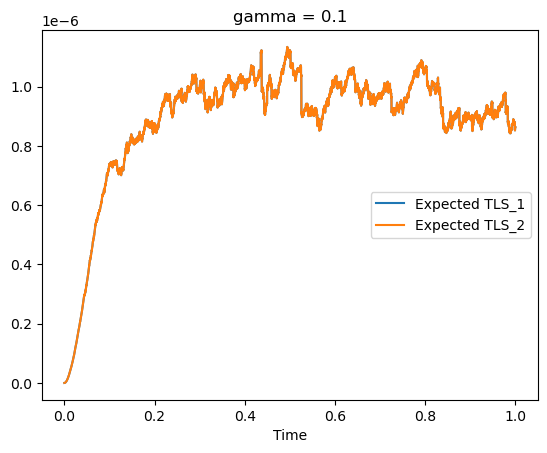

In [487]:
plt.plot(times, data.expect[0], label="Expected TLS_1")
plt.plot(times, data.expect[1], label="Expected TLS_2")
plt.xlabel("Time")
plt.title("gamma = 0.1")
plt.legend(loc="right")

In [1043]:
times = np.linspace(0.0, 10.0, 200)
psi0 = tensor(fock(2, 0), fock(10, 8))
a  = tensor(qeye(2), destroy(10))
sm = tensor(destroy(2), qeye(10))
H = 2*np.pi*a.dag()*a + 2*np.pi*sm.dag()*sm + 2*np.pi*0.25*(sm*a.dag() + sm.dag()*a)
data = mcsolve(H, psi0, times, [np.sqrt(0.1) * a], e_ops=[a.dag() * a, sm.dag() * sm])

10.0%. Run time:   0.25s. Est. time left: 00:00:00:02
20.0%. Run time:   0.43s. Est. time left: 00:00:00:01
30.0%. Run time:   0.61s. Est. time left: 00:00:00:01
40.0%. Run time:   0.79s. Est. time left: 00:00:00:01
50.0%. Run time:   0.97s. Est. time left: 00:00:00:00
60.0%. Run time:   1.15s. Est. time left: 00:00:00:00
70.0%. Run time:   1.33s. Est. time left: 00:00:00:00
80.0%. Run time:   1.51s. Est. time left: 00:00:00:00
90.0%. Run time:   1.69s. Est. time left: 00:00:00:00
100.0%. Run time:   1.86s. Est. time left: 00:00:00:00
Total run time:   1.86s
